# Tempo

Tempo should be measured as either the amount of passes and dribbles per time frame, or the speed of those per time frame. It could also include for example goal kicks, free kicks, corner kicks and even shots. Let's start with passes and dribbles.

In [95]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [96]:
# read data
df = pd.read_csv('../data/timelines.csv')

In [97]:
# unique match pairs
unique_match_ids = df['match_id'].unique()
df[(df['match_id'].isin(unique_match_ids)) & (df['match_id'] != df['match_id'].shift(1))][['home_team', 'away_team', 'year']].value_counts().reset_index(name='count')

,home_team,away_team,year,count
0,EPS T2010,K3 SPL United T2010,2024,2
1,Brommapojkarna T2009,HJK T2009,2022,1
2,Midtjylland P2010,EPS P2010,2022,1
3,Nordsjaelland T2008,TPS T2008,2022,1
4,Nordsjaelland T2008,SPL United 1 T2008,2022,1
5,Nordsjaelland T2008,HJK T2008,2022,1
6,Midtjylland P2011,Shamrock P2011,2023,1
7,Midtjylland P2011,PPJ P2011,2023,1
8,Midtjylland P2011,HJK P2011,2023,1
9,Midtjylland P2010,Suomi Future P2010,2024,1


In [98]:
# head
df.head(1)

,tournament_id,match_id,event_type,period,result,team,seconds_from_period_start,start_time,end_time,start_position_x,...,speed,home_team,away_team,home_team_int,away_team_int,age,year,distance,duration,int_level
0,57,1257,KickOff,1.0,NaN,Home,NaN,NaN,NaN,NaN,...,NaN,FC Espoo T2010,EPS T2010,0,0,F12,2022,NaN,NaN,0


In [99]:
# group by matches
df_matches = df.groupby('match_id')

In [100]:
# get matches with time gaps between events of over 50 seconds
threshold = 50

# Compute time gaps
df['time_gap'] = df_matches['seconds_from_period_start'].diff()

# Identify matches with gaps above threshold
df['gap_exceeds_threshold'] = df['time_gap'] > threshold
df['gap_exceeds_threshold_300'] = df['time_gap'] > 300

In [101]:
# get matches where two consecutive events are kick-offs
df['consecutive_kickoffs'] = (df['event_type'] == 'KickOff') & (df['event_type'].shift(1) == 'KickOff')

In [102]:
# get matches with under 300 events
event_counts = df.groupby('match_id').size().reset_index(name='event_count')
too_few_events_ids = event_counts['match_id'][event_counts['event_count'] < 300]

We should decide which matches we want to keep. Some matches have large gaps between events, which could be pauses in the match or an error of the data gathering system. Below are a few options.

In [103]:
# remove matches where two consecutive events are kickoffs and have at least a 50 second gap
# remove_match_indices = df[(df['gap_exceeds_threshold'] == True) & (df['consecutive_kickoffs'] == True)]['match_id'].unique()
# df = df[~df['match_id'].isin(remove_match_indices)]

In [104]:
# remove matches with time gaps of over five minutes and matches with less than 300 events
remove_match_indices = df[(df['gap_exceeds_threshold_300'] == True)]['match_id'].unique()
remove_match_indices = list(set(remove_match_indices) | set(too_few_events_ids))
df = df[~df['match_id'].isin(remove_match_indices)].copy()

### Plotting

In [105]:
# Function to calculate passes, dribbles & shots per timeframe
def calculate_tempo(df, timeframe):
    
    # Create time bins
    df.loc[:,'time_bin'] = (df['seconds_from_period_start'] // timeframe) * timeframe
    
    # Count passes, dribbles & shots per time bin
    df = df[df['event_type'].isin(['Pass', 'Dribble', 'Shot'])] \
        .groupby(['match_id', 'time_bin', 'age', 'int_level']).size().reset_index(name='tempo')
    
    return df

In [106]:
# get the tempo dataframe
tempo_df = calculate_tempo(df, 300)

In [107]:
tempo_df['time_bin'].value_counts()

time_bin
600.0     430
900.0     430
1200.0    430
300.0     429
1500.0    429
0.0       428
1800.0    405
2100.0    299
2400.0    263
2700.0     19
3000.0     13
3300.0      1
Name: count, dtype: int64

We can see that only a few matches have played over the 2400 second mark. We should ignore these time bins as they are not representative of the population.

In [108]:
# exclude the last incomplete time frames

# Find the max time_bin for each match_id
max_time_bins = tempo_df.groupby('match_id')['time_bin'].transform('max')

# Keep only rows where time_bin is NOT the max for that match
tempo_df = tempo_df[tempo_df['time_bin'] != max_time_bins]
tempo_df = tempo_df[tempo_df['time_bin'] <= 2400]

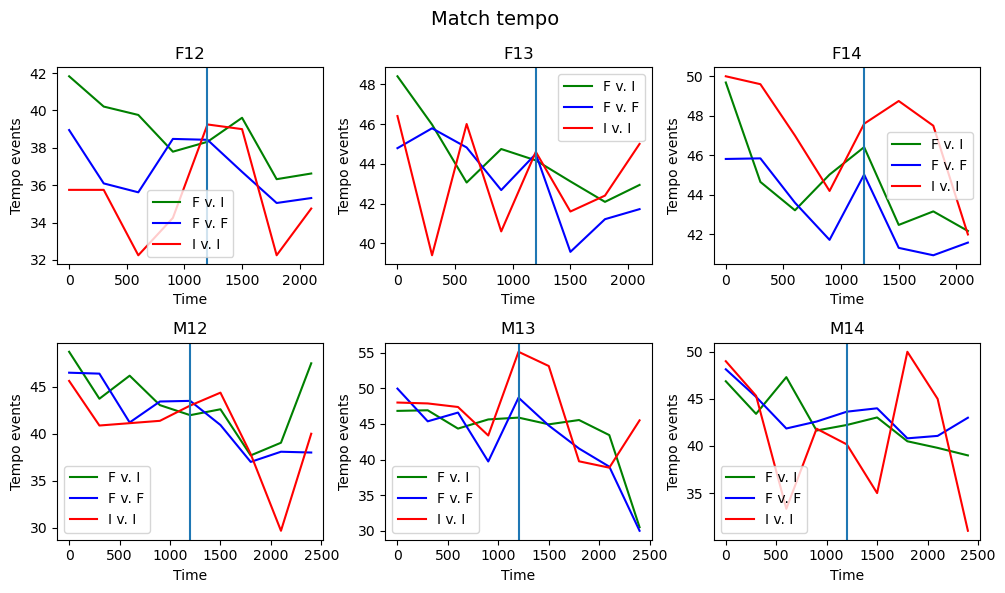

In [109]:
# plot tempo in a line plot by age groups
fig, axes = plt.subplots(2,3, figsize=(10,6))

colors = ['blue', 'green', 'red']

axes = axes.flatten()

df_grouped = tempo_df.groupby('age')

for i, (group_name, df_group) in enumerate(df_grouped):

    # Group by int_level within each age group
    int_levels = df_group['int_level'].unique()  # Get unique intensity levels

    for level in int_levels: # [1, 0, 2]
        subset = df_group[df_group['int_level'] == level]
        avg = subset.groupby('time_bin')['tempo'].mean()
        axes[i].plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')

    axes[i].set_title(group_name)
    axes[i].axvline(1200)
    axes[i].legend()  # Add legend to differentiate int_level categories
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Tempo events')

fig.suptitle('Match tempo', fontsize=14)
plt.tight_layout()

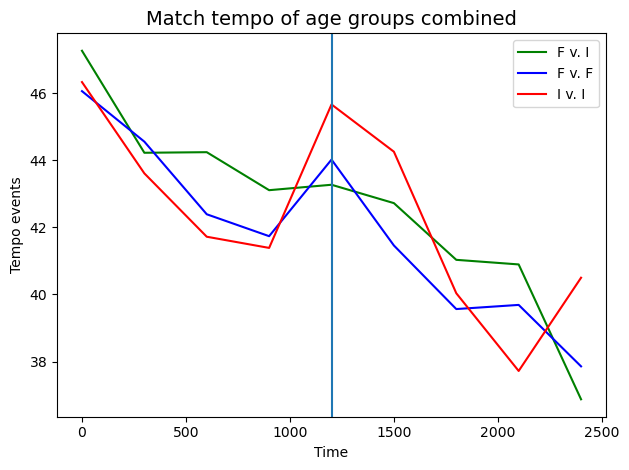

In [110]:
# plot tempo

colors = ['blue', 'green', 'red']

# Group by int_level within each age group
int_levels = tempo_df['int_level'].unique()  # Get unique intensity levels

for level in int_levels: # [1, 0, 2]
    subset = tempo_df[tempo_df['int_level'] == level]
    avg = subset.groupby('time_bin')['tempo'].mean()
    plt.plot(avg, color=colors[level], label=f'{['F v. F', 'F v. I', 'I v. I'][level]}')

plt.title('Match tempo of age groups combined', fontsize=14)
plt.axvline(1200)
plt.legend()  # Add legend to differentiate int_level categories
plt.xlabel('Time')
plt.ylabel('Tempo events')

plt.tight_layout()

We will focus next on the team-wise tempo per possession. For this we need to first derive the team in position in each moment. Then we can derive the duration of said possession, and calculate the amount of passes and dribbles per possession.

In [111]:
# simplify data frame
simple_df = df[['match_id', 'event_type', 'team', 'result', 'seconds_from_period_start', 'home_team_int', 'away_team_int', 'age', 'time_gap', ]]

In [112]:
# single match
single_match = simple_df[simple_df['match_id'] == 1237].copy()

In [113]:
# create a possession identifier by checking when the value changes
single_match.loc[:, 'possession_id'] = (single_match['team'] != single_match['team'].shift()).cumsum()

# calculate possession duration
single_match.loc[:, 'possession_duration'] = single_match.groupby('possession_id')['seconds_from_period_start'].transform('max') - \
                            single_match.groupby('possession_id')['seconds_from_period_start'].transform('min')

# compute average pass gap in possession to help reduce gaps
single_match.loc[:, 'prev_event_type'] = single_match.groupby('possession_id')['event_type'].shift(1)
home_pass_avg_gap = single_match.loc[(single_match['event_type'] == 'Pass') & (single_match['prev_event_type'] == 'Pass') & (single_match['team'] == 'Home'), 'time_gap'].mean()
away_pass_avg_gap = single_match.loc[(single_match['event_type'] == 'Pass') & (single_match['prev_event_type'] == 'Pass') & (single_match['team'] == 'Away'), 'time_gap'].mean()

# Filter possessions that have at least 3 events
valid_possessions = single_match.groupby(['match_id', 'team', 'possession_id']).filter(lambda x: len(x) >= 3)

# Detect if any possession has a gap ≥ 10 seconds
possessions_with_gaps = (
    valid_possessions.groupby(['match_id', 'team', 'possession_id'])
    .apply(lambda x: x.iloc[1:]['time_gap'].max())  # Skip the first row, then find max
    .reset_index(name='max_time_gap')  # Ensure it's a DataFrame
)
possessions_with_gaps['has_large_gap'] = possessions_with_gaps['max_time_gap'] >= 10

# Group by possession and calculate tempo event counts
df_possessions = valid_possessions.groupby(['match_id', 'possession_id']).agg(
    pos_duration=('possession_duration', 'first'),
    tempo_event_count=('event_type', lambda x: x.isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick']).sum()),  # Count passes
).reset_index()

df_possessions = df_possessions.merge(possessions_with_gaps, on=['match_id', 'possession_id'], how='left')

# remove large gaps from possessions to limit pauses in possessions
df_possessions['new_possession_duration'] = df_possessions.apply(
    lambda row: row['pos_duration'] - (row['max_time_gap'] - home_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Home')) 
                    else (row['pos_duration'] - (row['max_time_gap'] - away_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Away'))
                    else row['pos_duration']),
    axis=1)

# Calculate tempo as events per minute
df_possessions['pos_tempo'] = (df_possessions['tempo_event_count']) / (df_possessions['pos_duration']/60)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4572\1090885820.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.iloc[1:]['time_gap'].max())  # Skip the first row, then find max


In [114]:
grouped_matches = simple_df.groupby('match_id')

for group_name, df_group in grouped_matches:

    # create a possession identifier by checking when the value changes
    df_group.loc[:, 'possession_id'] = (df_group['team'] != df_group['team'].shift()).cumsum()

    # calculate possession duration
    df_group.loc[:, 'possession_duration'] = df_group.groupby('possession_id')['seconds_from_period_start'].transform('max') - \
                                df_group.groupby('possession_id')['seconds_from_period_start'].transform('min')

    # compute average pass gap in possession to help reduce gaps
    df_group.loc[:, 'prev_event_type'] = df_group.groupby('possession_id')['event_type'].shift(1)
    home_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Home'), 'time_gap'].mean()
    away_pass_avg_gap = df_group.loc[(df_group['event_type'] == 'Pass') & (df_group['prev_event_type'] == 'Pass') & (df_group['team'] == 'Away'), 'time_gap'].mean()

    # Filter possessions that have at least 3 events
    valid_possessions = df_group.groupby(['match_id', 'team', 'possession_id']).filter(lambda x: len(x) >= 3)

    # Detect if any possession has a gap ≥ 10 seconds
    possessions_with_gaps = (
        valid_possessions.groupby(['match_id', 'team', 'possession_id'])['time_gap']
        .apply(lambda x: x.iloc[1:].max())  # Skip first row and take max
        .reset_index(name='max_time_gap')
    )
    possessions_with_gaps['has_large_gap'] = possessions_with_gaps['max_time_gap'] >= 10

    # Group by possession and calculate tempo event counts
    df_possessions = valid_possessions.groupby(['match_id', 'possession_id']).agg(
        pos_duration=('possession_duration', 'first'),
        tempo_event_count=('event_type', lambda x: x.isin(['Pass', 'Dribble', 'Shot', 'ThrowIn', 'FreeKick', 'GoalKick', 'CornerKick']).sum()),  # Count passes
    ).reset_index()

    df_possessions = df_possessions.merge(possessions_with_gaps, on=['match_id', 'possession_id'], how='left')

    # remove large gaps from possessions to limit pauses in possessions
    df_possessions['new_possession_duration'] = df_possessions.apply(
        lambda row: row['pos_duration'] - (row['max_time_gap'] - home_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Home')) 
                        else (row['pos_duration'] - (row['max_time_gap'] - away_pass_avg_gap) if ((row['has_large_gap']) & (row['team'] == 'Away'))
                        else row['pos_duration']),
        axis=1)

    # Calculate tempo as events per minute
    df_possessions['pos_tempo'] = (df_possessions['tempo_event_count']) / (df_possessions['pos_duration']/60)

In [118]:
df_possessions

,match_id,possession_id,pos_duration,tempo_event_count,team,max_time_gap,has_large_gap,new_possession_duration,pos_tempo
0,3301,2,0.0,2,Home,NaN,False,0.000000,inf
1,3301,4,7.0,3,Home,5.0,False,7.000000,25.714286
2,3301,10,40.0,7,Away,19.0,True,25.366667,10.500000
3,3301,16,13.0,3,Away,8.0,False,13.000000,13.846154
4,3301,22,21.0,3,Away,16.0,True,9.366667,8.571429
5,3301,24,24.0,10,Home,6.0,False,24.000000,25.000000
6,3301,31,22.0,6,Home,8.0,False,22.000000,16.363636
7,3301,40,11.0,5,Home,4.0,False,11.000000,27.272727
8,3301,44,5.0,3,Away,3.0,False,5.000000,36.000000
9,3301,54,30.0,4,Home,23.0,True,11.579365,8.000000


In [117]:
# pd.options.display.max_rows = 600
# simple_df[simple_df['match_id'] == 1237]

In [116]:
# create dataframe with columns: 'match_id', 'team', 'pos_event_amt', 'pos_duration', 'pos_tempo'
def calculate_tempo_per_possession(df):

    # Group by match
    grouped_mathces = df.groupby(['match_id', 'age'])

    for group_name, df_group in grouped_mathces:
        
    
    # Filter possessions longer than two events
    possession_stats = possession_stats[possession_stats['passes_and_dribbles'] > 2]
    
    # Compute tempo for each possession
    possession_stats['tempo'] = possession_stats['passes_and_dribbles'] / possession_stats['possession_time']
    
    # Aggregate by team
    team_stats = possession_stats.groupby('team').agg(
        total_passes_dribbles=('passes_and_dribbles', 'sum'),
        total_possession_time=('possession_time', 'sum'),
        average_tempo=('tempo', 'mean')  # Average tempo of possessions
    ).reset_index()
    
    # Compute tempo for the match (total events / total possession time)
    team_stats['match_tempo'] = team_stats['total_passes_dribbles'] / team_stats['total_possession_time']
    
    return df

# Calculate tempo
tempo_df = calculate_tempo(simple_df)
tempo_df


IndentationError: expected an indented block after 'for' statement on line 7 (3524225432.py, line 11)